## CCU - literature overview

In [49]:
# Load some libraries for reading the data from the database and plotting 

import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

from django.db.models import Count, Sum

In [50]:
p = Project.objects.get(pk=106)
dos = DocOwnership.objects.filter(query__project=p,relevant__in=[1,2,3])
dos.count()


12838

In [51]:
ratings = pd.DataFrame.from_dict(list(dos.order_by('finish').values(
    'finish','user__username','relevant'
)))

ratings['cumsum']=ratings.index
ratings.head()


,finish,relevant,user__username,cumsum
0,2018-11-05 14:11:32.553465+00:00,1,vicl,0
1,2018-11-05 14:13:33.473189+00:00,2,vicl,1
2,2018-11-05 14:14:30.634022+00:00,2,vicl,2
3,2018-11-05 14:15:48.387171+00:00,2,vicl,3
4,2018-11-05 14:22:05.033141+00:00,1,vicl,4


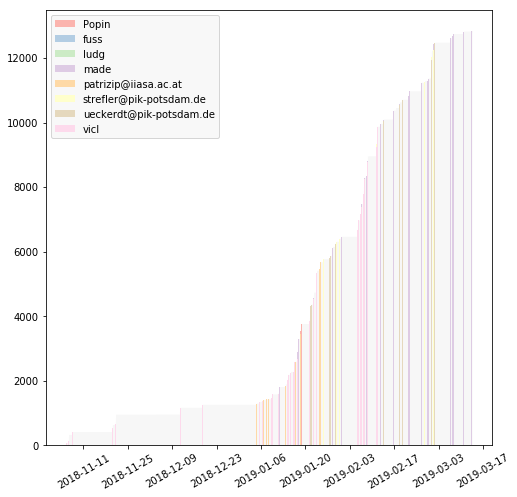

In [52]:
fig, ax = plt.subplots( figsize=(8,8))

times = [d.to_pydatetime() for d in ratings['finish']]

ax.fill_between(times,0,ratings['cumsum'],color="#f7f7f7")

markers = ('o','v','^','1','s','P','+','x','D')
cols = ["None","green","red","orange"]
cols = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec']
for i, (name, group) in enumerate(ratings.groupby('user__username')):
    times = [d.to_pydatetime() for d in group['finish']]
    ax.bar(
        times,
        group['cumsum'],
        label=name,
        width=0.2,
        color=cols[i]
        #s=15, 
        #marker=markers[i],
    )
    #ax.bar(times, group['cumsum'])
    
plt.setp(ax.get_xticklabels(), rotation=30)

plt.legend(facecolor="#f7f7f7")
plt.show()

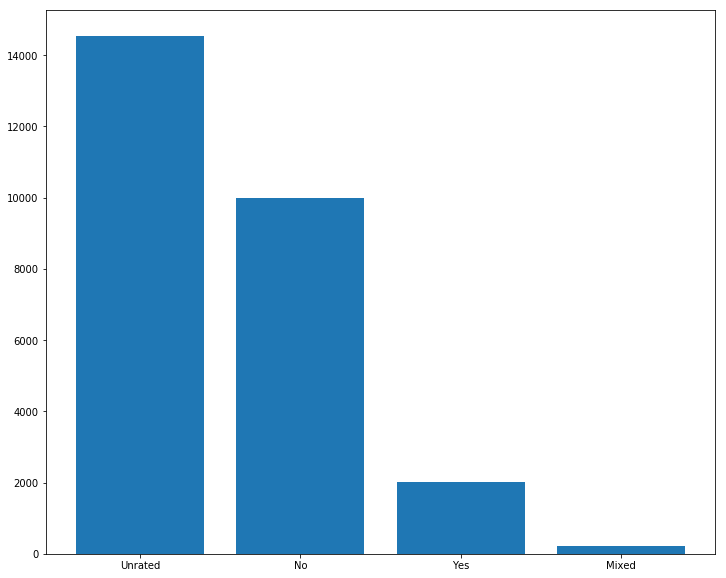

In [53]:
# How many documents are relevant or not
rel = list(Doc.objects.filter(docproject__project=p).values('docproject__relevant').annotate(
    n = Count('pk') # Count the pk - primary keys - of documents with each value
).order_by('-n'))

for r in rel: # get the full name of relevance
    r['relevant'] = DocProject.Relevance[r['docproject__relevant']][1]

# Put this into a dataframe
rel_df = pd.DataFrame.from_dict(rel) # we have to wrap the queryset in a list, so pandas can read it properly
rel_df.tail() # what do the last few rows look like?

fig, ax = plt.subplots()

ax.bar(rel_df.index,rel_df['n'])
ax.set_xticks(rel_df.index)
ax.set_xticklabels(rel_df['relevant'])

plt.show()

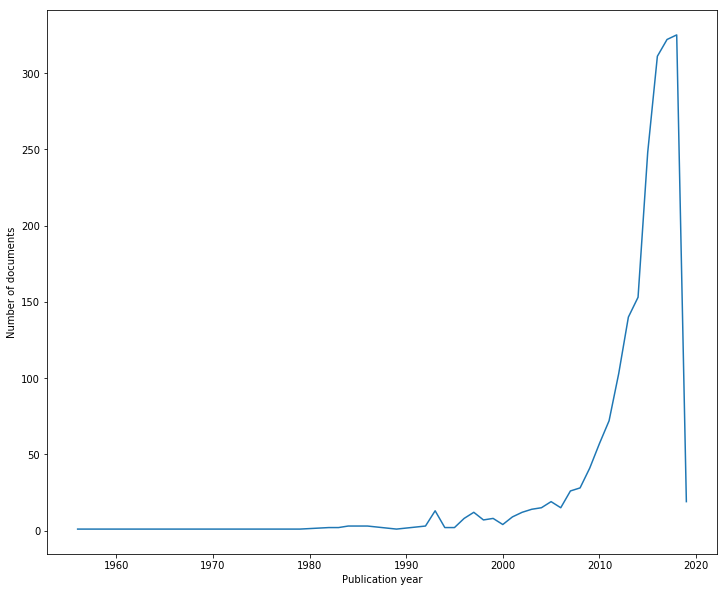

In [54]:
docs = Doc.objects.filter(docproject__project=p,docproject__relevant=1)
# how many documents in each year of each relevance category?
by_year = list(docs.values('PY').annotate(
    n = Count('pk') # Count the pk - primary keys - of documents in each value of PY (year)
).order_by('PY'))

# Put this into a dataframe
by_year_df = pd.DataFrame.from_dict(list(by_year)) # we have to wrap the queryset in a list, so pandas can read it properly

plt.plot(by_year_df['PY'],by_year_df['n'],label=name)
# Add some labels
plt.xlabel('Publication year')
plt.ylabel('Number of documents')

In [129]:
from utils.utils import ars

syear = 1985
ybin = 5

bypy = docs.filter(
       PY__in=range(syear,2019)
).values('PY').annotate(
    n = Count('UT', distinct=True)
).order_by('PY')

bypy = []
for py in range(syear,2019):
    pn = (py-syear)//ybin
    pyd = {"PY": py}
    pyd['ar'] = pn
    pyd['ar_name'] = f"{syear+ybin*pn} - {syear+ybin*(pn+1)-1}"
    pyd['n'] = docs.filter(PY=py).count()
    bypy.append(pyd)


bypy = pd.DataFrame.from_dict(list(bypy))

bypy.head()

bypy.tail()

,PY,ar,ar_name,n
29,2014,5,2010 - 2014,153
30,2015,6,2015 - 2019,248
31,2016,6,2015 - 2019,311
32,2017,6,2015 - 2019,322
33,2018,6,2015 - 2019,325


In [130]:
doc_dict = []

ts = Category.objects.filter(project=p,level=1)

#allreldocs = Doc.objects.filter(query=q)
pys = list(range(syear,2019))
for t in ts:
    if t.level==2:
        continue
    for py in pys:           
        ydocs = docs.filter(PY=py)
        if t.name=="Other mineralisation products":
            mins = [t] + list(Category.objects.filter(parent_category=t))
            trdocs = set(list(ydocs.filter(
                query__category__in=mins,docownership__relevant=1,docownership__query__category__in=mins
            ).values_list('UT',flat=True)))
            ttdocs = set(list(ydocs.filter(
                category__in=mins
            ).values_list('UT',flat=True)))
        else:          
            trdocs = set(list(ydocs.filter(
                query__category=t,docownership__relevant=1,docownership__query__category=t
            ).values_list('UT',flat=True)))
            ttdocs = set(list(ydocs.filter(
                category=t
            ).values_list('UT',flat=True)))
            
        tdocs = Doc.objects.filter(
            UT__in=trdocs.union(ttdocs)
        )
        d = {
            'Technology': t.name,
            'PY': py,
            'n': tdocs.count()
        }
        doc_dict.append(d)
        
for py in doc_dict:
    pn = (py['PY']-syear)//ybin
    py['ar'] = pn
    py['ar_name'] = f"{syear+ybin*pn} - {syear+ybin*(pn+1)-1}"


        
df = pd.DataFrame.from_dict(doc_dict)

techorder = list(df.groupby('Technology')['n'].sum().sort_values(ascending=False).index)

df['Technology'] = pd.Categorical(
    df['Technology'],
    techorder
)

df['ysum'] = df['n'].groupby(df['PY']).transform('sum')

df['share'] = df['n'] / df['ysum'] * 100
df.head()

,PY,Technology,ar,ar_name,n,ysum,share
0,1985,Biofuel from algae,0,1985 - 1989,0,3,0.0
1,1986,Biofuel from algae,0,1985 - 1989,0,3,0.0
2,1987,Biofuel from algae,0,1985 - 1989,0,0,NaN
3,1988,Biofuel from algae,0,1985 - 1989,0,0,NaN
4,1989,Biofuel from algae,0,1985 - 1989,0,1,0.0


In [131]:

ardf = df[['Technology','ar_name','n']].groupby(['ar_name','Technology']).sum()

ardf = ardf.reset_index()

ardf['ysum'] = ardf['n'].groupby(ardf['ar_name']).transform('sum')

ardf['share'] = ardf['n'] / ardf['ysum'] * 100

ardf.head()

,ar_name,Technology,n,ysum,share
0,1985 - 1989,Other mineralisation products,0,7,0.000000
1,1985 - 1989,Cement/concrete production,3,7,42.857143
2,1985 - 1989,Biofuel from algae,0,7,0.000000
3,1985 - 1989,EOR,4,7,57.142857
4,1985 - 1989,Polymers and bioplastics,0,7,0.000000


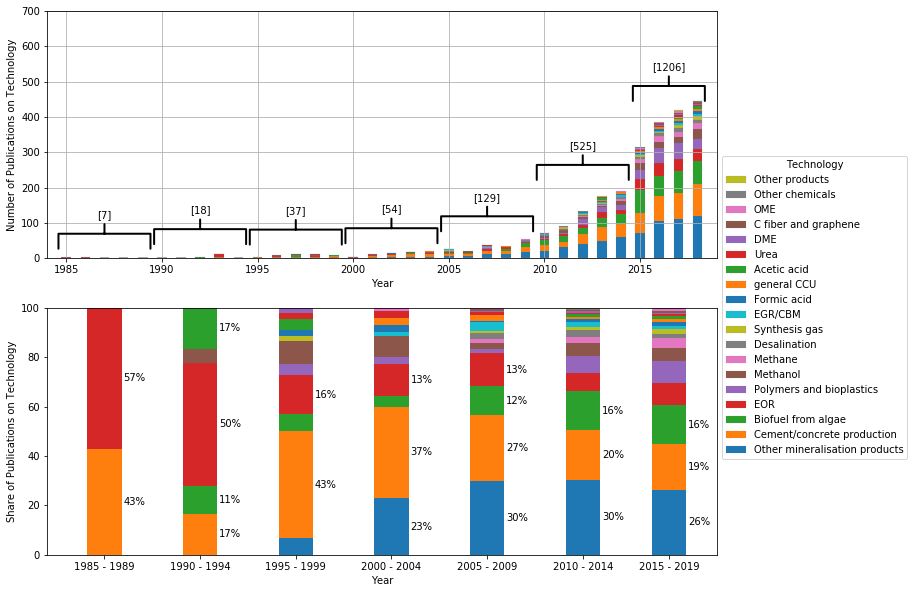

In [144]:
xmin = -1#0#1.5


plt.rcParams["figure.figsize"] = [12,10]

both_axes = True

if both_axes:
    fig, axs = plt.subplots(2,1)
    ax = axs[0]
    ax2 = axs[1]
else:
    fig, ax = plt.subplots(1,1)
    
pdf = df.pivot(
    index='PY',
    columns='Technology',
    values='n'
)#.fillna(0)


pdf.plot.bar(
    stacked=True, 
    ax=ax,
    legend=False,    
    lw=0.1,
    edgecolor='grey'#,
    #align='center'
)



handles, labels = ax.get_legend_handles_labels()

ylabs = [1985,1990,1995,2000,2005,2010,2015]
yts = [x-syear for x in ylabs]


ax.xaxis.set_ticks(yts)
ax.xaxis.set_ticklabels(ylabs)

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

plt.legend(handles[::-1], labels[::-1],title='Technology',loc="center left",bbox_to_anchor=(1, 1))

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications on Technology')

ax.grid(True)

ax.set_xlim(xmax=2018-syear-xmin)
ax.set_xlim(xmin=xmin)
ax.set_ylim(ymax=700)

if both_axes:
    mids = []

    ticklabels = []
    for name, group in bypy.groupby('ar_name'):
        ticklabels.append(name)
        count = "[{}]".format(group['n'].sum())
        miny = group['PY'].min() - syear 
        maxy = group['PY'].max() - syear 
        width = maxy-miny + 0.6
        bwidth = 1.8
        mid = group['PY'].median() - syear 
        mids.append(mid)
        maxn = group['n'].max() *1.3 + 60
        #ax.text(mid,maxn,count,ha="center")
        ar = group['ar'].max()
        ax.annotate(
            count,
            xy=(mid,maxn),
            xytext=(mid,maxn+50),
            ha="center",
            arrowprops=dict(arrowstyle='-[, widthB={}, lengthB=1.5'.format(width), lw=2.0)
        )
        art = ardf[ardf['ar_name']==name]
        b = 0
        h = 0
        for t in techorder:
            v = art[art['Technology']==t]
            if not v.empty:
                v = float(v['share'])
                ax2.bar(
                    mid,v,bottom=b,align="center",
                    width=bwidth,color=handles[h].patches[0]._facecolor
                )        
                if v > 10:
                    ax2.text(mid+bwidth*0.5+0.1,b+v*0.5,"{}%".format(round(v)),va="center")
                b+=v
            h+=1

    ax = ax2

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)


    #legend = plt.legend(position="right")#handles[::-1], labels[::-1],title='Technology')
    #legend.remove()

    ax.xaxis.set_ticks(mids)
    ax.xaxis.set_ticklabels(ticklabels)

    ax.set_xlabel('Year')
    ax.set_ylabel('Share of Publications on Technology')

    ax.set_xlim(xmax=2018-syear-xmin)
    ax.set_xlim(xmin=xmin)

plt.savefig('plots/all_ars.png',bbox_inches='tight') 
plt.savefig('plots/all_ars.eps',bbox_inches='tight') 
plt.savefig('plots/all_ars.svg',bbox_inches='tight') 

plt.show()




In [128]:
ardf

,ar_name,Technology,n,ysum,share
0,1986 - 1990,Other mineralisation products,0,4,0.000000
1,1986 - 1990,Cement/concrete production,1,4,25.000000
2,1986 - 1990,Biofuel from algae,0,4,0.000000
3,1986 - 1990,EOR,3,4,75.000000
4,1986 - 1990,Polymers and bioplastics,0,4,0.000000
5,1986 - 1990,Methanol,0,4,0.000000
6,1986 - 1990,Methane,0,4,0.000000
7,1986 - 1990,Desalination,0,4,0.000000
8,1986 - 1990,Synthesis gas,0,4,0.000000
9,1986 - 1990,EGR/CBM,0,4,0.000000


In [103]:
df[(df['ar']==1)].head()

,PY,Technology,ar,ar_name,n,ysum,share
5,1990,Biofuel from algae,1,1990 - 1994,0,0,NaN
6,1991,Biofuel from algae,1,1990 - 1994,0,0,NaN
7,1992,Biofuel from algae,1,1990 - 1994,0,3,0.000000
8,1993,Biofuel from algae,1,1990 - 1994,2,13,15.384615
9,1994,Biofuel from algae,1,1990 - 1994,0,2,0.000000


In [109]:
pdf

Technology,Cement/concrete production,Other mineralisation products,EOR,Methane,Biofuel from algae,Synthesis gas,OME,Methanol,Polymers and bioplastics,Desalination,EGR/CBM,Acetic acid,Formic acid,C fiber and graphene,Urea,DME,Other chemicals,Other products,general CCU
PY,,,,,,,,,,,,,,,,,,,
1985,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1986,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1989,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1992,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1993,3,0,6,0,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0


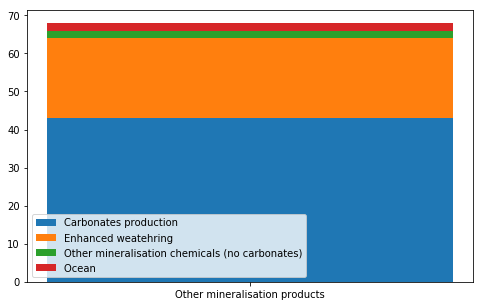

In [105]:
b = 0

fig, ax = plt.subplots(figsize=(8,5))
scs = []
for t in Category.objects.filter(project=p,level=2).order_by('-ndocs'):
    trdocs = set(list(ydocs.filter(
        query__category=t,docownership__relevant=1,docownership__query__category=t
    ).values_list('UT',flat=True)))
    ttdocs = set(list(ydocs.filter(
        category=t
    ).values_list('UT',flat=True)))
    tdocs = Doc.objects.filter(
        UT__in=trdocs.union(ttdocs)
    )    
    scs.append({
        'title': t.name,
        'n': tdocs.count()
    })

sdf = pd.DataFrame.from_dict(scs).sort_values('n',ascending=False)

for i, row in sdf.iterrows():  
    ax.bar(1,row['n'],bottom=b, label=row['title'])
    t = "\n".join(row['title'].split())
    #ax.text(1.45, b+row['n']/2, row['title'].replace(' chem','\nchem'),va="top")
    b+=row['n']
    
plt.legend()

ax.xaxis.set_ticks([1])
ax.xaxis.set_ticklabels(["Other mineralisation products"])
    

plt.savefig('plots/other_mineralisation.png',bbox_inches='tight') 
plt.savefig('plots/other_mineralisation.eps',bbox_inches='tight') 
plt.savefig('plots/other_mineralisation.svg',bbox_inches='tight') 

plt.show()
    
fig.tight_layout()